# Collecting and wrangling data

The goal is to create a dataframe by merging existing user data with generated data. The data will be used in machine learning classification algorithms to determine which lesson items should be removed.

The dataframe should have:
+ data about 'clone' lesson items (obtained using NLP)
+ accuracy data for problem and theory lesson items
+ duration data for problem and theory lesson items
+ z-score accuracy data for problem and theory lesson items
+ z-score duration data for problem and theory lesson items
+ overall lesson duration data
+ theory/problem indices indicating whether a lesson item is a theory or problem item
+ data from a human expert on which items were selected to be removed 


In [1]:
from docx import *
import re, glob, os
import numpy as np
import scipy as sp
from bs4 import BeautifulSoup
import zipfile
import sklearn
import tempfile
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram
from IPython.display import display, HTML

from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
%pylab -- inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##1- Running NLP analysis code from python files

In [3]:
%run 'C:/Users/eabalo/Desktop/STAAR35Analyses/src/STAAR_preprocessing_code.py'
%run 'C:/Users/eabalo/Desktop/STAAR35Analyses/src/LSA_code.py'

## 2- Data Munging/Wrangling

In [88]:
#data folder
datafolder = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

In [89]:
#Data collected from users
df_deliv1 = pd.read_csv(datafolder + 'df_deliv1.csv')
df_deliv2 = pd.read_csv(datafolder + 'df_deliv2.csv')
df_lesson = pd.read_csv(datafolder + 'df_lesson.csv')
df_problem = pd.read_csv(datafolder + 'df_problem.csv')
df_labels = pd.read_csv(datafolder + 'df_labels.csv')

In [90]:
#column headers and dataframe dimensions
for i in [df_deliv1, df_deliv2, df_problem, df_lesson, df_labels]:
    print i.columns, '\n', i.shape, '\n'

Index([u'Theory UID', u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'50th percentile duration', u'80th percentile duration', u'ACCURACY',
       u'Accuracy/Duration'],
      dtype='object') 
(907, 8) 

Index([u'Problem UID', u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'Dataset', u'Problem-Dataset Accuracy %', u'IS Accuracy (%)',
       u'Problem input control', u'Most common FR incorrect',
       u'% of most common FR incorrect', u'Most common MC incorrect',
       u'% of most common MC incorrect'],
      dtype='object') 
(3752, 12) 

Index([u'Grade level', u'Problem UID', u'Accuracy',
       u'50th percentile duration', u'80th percentile duration',
       u'Used hints week', u'Used hints AY', u'Additional Problem',
       u'Accuracy/Duration', u'Lesson', u'Supporting/Readiness'],
      dtype='object') 
(769, 11) 

Index([u'Grade Level', u'Lesson', u'#assigned during this week',
       u'#assigned during this AY', u'Accuracy for the week',
       u'Accurac

In [91]:
df_deliv1.describe();

In [92]:
#dropping columns
df_lesson.drop('Accuracy for the week', axis=1, inplace=True)

#renaming columns
df_lesson=df_lesson.rename(columns = {'Grade Level':'Grade level', 'Accuracy for the AY': 'Accuracy',
                                     'Time spent to complete 80% AY': '80th percentile duration',
                                     'Time spent to complete 50% AY': '50th percentile duration'})
df_problem = df_problem.rename(columns={'GRADE': 'Grade level',
                                        'Accuracy avg during AY': 'Accuracy',
                                       'Time spent (50% threshold)': '50th percentile duration',
                                       'Time spent (80% threshold)': '80th percentile duration'})
df_deliv1 = df_deliv1.rename(columns = {'ACCURACY':'Accuracy'})

#choosing non-'additional problem' data in df_problem
df_problem = df_problem[df_problem['Additional Problem'] == 0]

###2-1 Merging theory and problem data sets

In [93]:
#Merging theory and problem data sets
df_thpr = pd.concat([df_deliv1, df_problem])

#reordering and dropping columns
df_thpr = pd.DataFrame(data = df_thpr, columns = ['Lesson', 'Grade level', 'Supporting/Readiness', 'Theory UID', 'Problem UID', 
                   '50th percentile duration', '80th percentile duration','Accuracy', 'Accuracy/Duration'])

In [94]:
print df_thpr.columns
print df_thpr.shape

Index([u'Lesson', u'Grade level', u'Supporting/Readiness', u'Theory UID',
       u'Problem UID', u'50th percentile duration',
       u'80th percentile duration', u'Accuracy', u'Accuracy/Duration'],
      dtype='object')
(1676, 9)


### 2-2 Adding other features

In [95]:
#Theory index
theoryindex = []
for i in df_thpr['Theory UID']:
    #sl = i.split('-')
    if 'th' in str(i):
        theoryindex.append(1)
    else:
        theoryindex.append(0)

#Adding Theory index to df_thpr
df_thpr['Theory?'] = theoryindex

In [96]:
#UID of lesson item
df_thpr['UID'] = df_thpr['Theory UID']
df_thpr['UID'].fillna(df_thpr['Problem UID'], inplace=True)

#dropping columns
df_thpr.drop(['Theory UID', 'Problem UID'], axis=1, inplace=True)

In [97]:
#Z-scores of duration and accuarcy for a given lesson and theory/problem items
#http://pandas.pydata.org/pandas-docs/version/0.13.1/groupby.html
zscore = lambda x: (x - x.mean()) / x.std()

df_thpr['Duration z-score'] = df_thpr.groupby(['Lesson', 'Theory?']).transform(zscore)['80th percentile duration']

df_thpr['Accuracy z-score'] = df_thpr.groupby(['Lesson', 'Theory?']).transform(zscore)['Accuracy']

In [98]:
#Adding overall lesson duration (80th percentile time) to df_thpr

df_temp = pd.DataFrame()
df_temp[['Lesson', 'Lesson duration']] = df_lesson[['Lesson', '80th percentile duration']]

df_thpr = pd.merge(df_thpr, df_temp, on='Lesson')

In [99]:
print df_thpr.columns
print df_thpr.shape

Index([u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'50th percentile duration', u'80th percentile duration', u'Accuracy',
       u'Accuracy/Duration', u'Theory?', u'UID', u'Duration z-score',
       u'Accuracy z-score', u'Lesson duration'],
      dtype='object')
(1676, 12)


#### Exporting df_thpr

In [100]:
#Exporting df_thpr

cleandatapath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

df_thpr.to_csv(cleandatapath + 'df_theoryProblem.csv', index=False)

###2-3 Selecting the 3 longest lessons per grade level per lesson type

In [101]:
#Finding the three longest lessons per grade per lesson type

#initializing empty datframe
df_temp0 = df_thpr[['Lesson', 'Supporting/Readiness', 'Grade level', 'Lesson duration']].copy(deep = True)
df_temp0.drop_duplicates(inplace = True)
df_temp1 = pd.DataFrame(columns = df_temp0.columns)
#df_temp.columns = df_thpr.columns

for lessontype in ['R', 'S']:
    for g in range(3,6):
        #duration
        if lessontype == 'S':
            durationlimit = 2700
            data = df_temp0[(df_temp0['Supporting/Readiness']=='S') & (df_temp0['Lesson duration']>durationlimit) & (df_temp0['Grade level']== g)].sort('Lesson duration', ascending=False).head(3)
        elif lessontype == 'R':
            durationlimit = 3600
            data = df_temp0[(df_temp0['Supporting/Readiness']=='R') & (df_temp0['Lesson duration']>durationlimit) & (df_temp0['Grade level']== g)].sort('Lesson duration', ascending=False).head(3)
        #appeding data to dataframe
        df_temp1 = df_temp1.append(data)

df_temp1;

In [102]:
print df_temp1['Lesson'].unique()

['308A' '305E' '306A' '404H' '404A' '405B' '504H' '503K' '509C' '308B'
 '304G' '307C' '408AB' '404F' '404D' '504D' '507A' '503B']


In [103]:
#Saving data for 3 longest lessons per grade per lesson type in dataframe
df_thpr2 = pd.DataFrame(columns = df_thpr.columns)

#Replacing '408AB' by '406C' because '406C' was analyzed instead of '408AB'
#After tests, the model can be run of 408AB
longlessons = ['308A', '305E', '306A', '404H', '404A', '405B', '504H', '503K', '509C', '308B',
 '304G', '307C', '404F', '404D', '406C', '504D', '507A', '503B']

for lesson in longlessons:
    data = df_thpr[df_thpr['Lesson'] == lesson]
    df_thpr2 = df_thpr2.append(data)

print df_thpr2['Lesson'].unique()

print df_thpr2.shape

df_thpr2.head();

['308A' '305E' '306A' '404H' '404A' '405B' '504H' '503K' '509C' '308B'
 '304G' '307C' '404F' '404D' '406C' '504D' '507A' '503B']
(345, 12)


####Some theory items have 0 accuracy because there are no submits in those lesson items. So the accuracy can be set to 0.

In [104]:
#fill missing data with 0:
df_thpr2.fillna(0, inplace=True);

###2-4 Adding clone index feature to data

Lesson items are labeled with 1 if they are similar to other lesson items in the same lesson or 0 if otherwise. The algorithm applied is Latent Semantic Analysis (LSA). Two or more lesson items are considered 'clones' if the similarity index obtained from LSA and cosine similarity is less than 0.001.

####Sample lesson

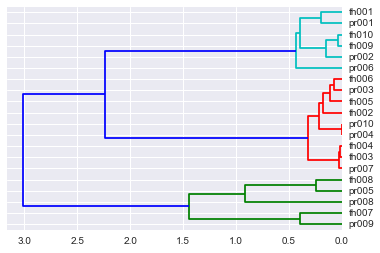

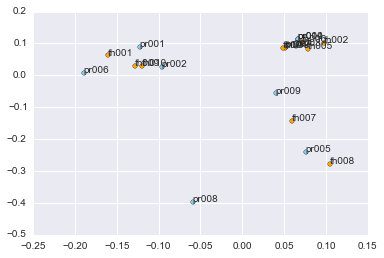

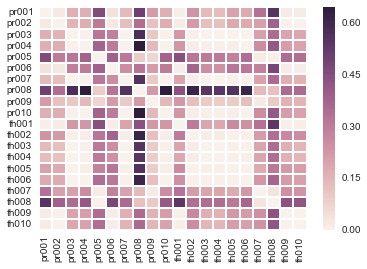

In [5]:
lessonpath = 'C:/Users/eabalo/Documents/STAAR2014/4g/405B/'
lsa_dendrogram(lessonpath)
lsa_mds_plot(lessonpath)
lsa_heatmap(lessonpath)

In [6]:
display(lsa_clone_index(lessonpath).head(7))
print lsa_clone_index(lessonpath).shape

,UID,Clone?
0,TEKS405B-pr001,0
1,TEKS405B-pr002,0
2,TEKS405B-pr003,1
3,TEKS405B-pr004,1
4,TEKS405B-pr005,0
5,TEKS405B-pr006,0
6,TEKS405B-pr007,1


(20, 2)


####Clone indices for longest lessons

In [ ]:
#folder of lessons
staarpath = 'C:/Users/eabalo/Documents/STAAR2014/'

df_clone = pd.DataFrame(columns=['UID', 'Clone?'])

#extracting text from lessons
for lessonname in df_thpr2['Lesson'].unique():
    
    grade = lessonname[0]+'g'
    
    lessonpath = staarpath + grade + '/' + lessonname + '/'
    
    df_clone = df_clone.append(lsa_clone_index(lessonpath))
    
    #lesson number
    #lessonname = lessonpath.split('/')[-2]

In [137]:
display(df_clone.head())
print df_clone.shape

,UID,Clone?
0,TEKS308A-pr001,0
1,TEKS308A-pr002,0
2,TEKS308A-pr003,0
3,TEKS308A-pr004,0
4,TEKS308A-pr005,0


(345, 2)


In [109]:
#Adding the 'Clone' feature to the data
df_thpr2 = pd.merge(df_thpr2, df_clone, on = 'UID')

In [110]:
print df_thpr2.columns

print df_thpr2.shape

Index([u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'50th percentile duration', u'80th percentile duration', u'Accuracy',
       u'Accuracy/Duration', u'Theory?', u'UID', u'Duration z-score',
       u'Accuracy z-score', u'Lesson duration', u'Clone?'],
      dtype='object')
(345, 13)


In [111]:
#Exporting data for 3 longest lessons per grade per lesson type (with Clone indices)

cleandatapath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

df_thpr2.to_csv(cleandatapath + 'df_longLessons.csv', index=False)

###2-5 Extracting classification data (for training data) from analysis document

18 lessons were analyzed by human experts and it was determined which items in the lessons were good candidates for removal. The results of the analysis are saved in a docx file. This information is extracted, processed, and merged with the existing data.

In [112]:
#Extracting classification data
docpath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/manuscript/Strategies_to_shorten_STAAR_lessons_2.docx'

doc = Document(docpath)

In [113]:
lessonnum = []
for table in doc.tables[1:]:
    for paragraph in table.rows[0].cells[1].paragraphs:
        lessonnum.append(paragraph.text)
print lessonnum

[u'3.8A', u'3.5E', u'3.6A', u'3.8B', u'3.4G', u'3.7C', u'4.4H', u'4.4A', u'4.4F', u'4.4D', u'4.5B', u'4.6C', u'5.4H', u'5.3K', u'5.9C', u'5.4D', u'5.7A', u'5.3B']


In [114]:
cloneinfo = []

for table in doc.tables[1:]:
    textinfo = ''
    for paragraph in table.rows[6].cells[1].paragraphs:
        textinfo += paragraph.text + ', '
    cloneinfo.append(textinfo)
print cloneinfo[:2]

[u'th090, th091 (6:57), pr001 (2:18), pr002 (2:17), pr003 (4:06), pr004 (1:11), pr005 (1:26), pr006 (1:45), ', u'pr001 (2:15), th030 (4:15), th050 (5:26), th060 (5:08), pr006* (2:17), ']


In [115]:
df_temp2 = pd.DataFrame(zip(lessonnum, cloneinfo), columns = ['Lesson', 'Cut?'])

In [116]:
display(df_temp2.head())
print df_temp2.shape

,Lesson,Cut?
0,3.8A,"th090, th091 (6:57), pr001 (2:18), pr002 (2:17..."
1,3.5E,"pr001 (2:15), th030 (4:15), th050 (5:26), th06..."
2,3.6A,"th008 (3:14), th010 (1:25), th019 (1:17), th02..."
3,3.8B,"pr001 (1:34), th060 (3:02), pr007 (1:47) (?), ..."
4,3.4G,"pr002 (3:04), pr003 (4:00), th001 (4:27), pr00..."


(18, 2)


In [117]:
#removing durations and other symbols from extracted data
df_temp2['Cut?'] = df_temp2['Cut?'].str.replace(r'\(.+?\)|\*', '')
df_temp2.head()

,Lesson,Cut?
0,3.8A,"th090, th091 , pr001 , pr002 , pr003 , pr004 ,..."
1,3.5E,"pr001 , th030 , th050 , th060 , pr006 ,"
2,3.6A,"th008 , th010 , th019 , th026, th027, th028, t..."
3,3.8B,"pr001 , th060 , pr007 , th130, th133, th137 ,..."
4,3.4G,"pr002 , pr003 , th001 , pr001 , th007 , pr004 ..."


In [118]:
#Correcting the placement of commas
df_temp2['Cut?'] = df_temp2['Cut?'].str.replace(r' ,', ',')
df_temp2.head()

,Lesson,Cut?
0,3.8A,"th090, th091, pr001, pr002, pr003, pr004, pr00..."
1,3.5E,"pr001, th030, th050, th060, pr006,"
2,3.6A,"th008, th010, th019, th026, th027, th028, th029,"
3,3.8B,"pr001, th060, pr007 , th130, th133, th137, th0..."
4,3.4G,"pr002, pr003, th001, pr001, th007, pr004, pr00..."


In [119]:
# function to standardize lesson names
# for example, it changes 3.2A to 302A, and 4.10AB to 410AB
def lessonname(string):
    a, b = string.split('.')
    output = ''
    if re.match(r'(\d{1})([A-Z]{1,3})', b):
        output += a + '0' + b
    elif re.match(r'(\d{2})([A-Z]{1,3})', b):
        output += a + b
    return output

df_temp2['Lesson'] = df_temp2['Lesson'].apply(lessonname)

In [120]:
df_temp2.head()

,Lesson,Cut?
0,308A,"th090, th091, pr001, pr002, pr003, pr004, pr00..."
1,305E,"pr001, th030, th050, th060, pr006,"
2,306A,"th008, th010, th019, th026, th027, th028, th029,"
3,308B,"pr001, th060, pr007 , th130, th133, th137, th0..."
4,304G,"pr002, pr003, th001, pr001, th007, pr004, pr00..."


In [121]:
#Reformatting data to get UID
lessonnum = df_temp2['Lesson']
lessonitems = df_temp2['Cut?']

cutitems = []
for i in range(len(lessonnum)):
    preuid = 'TEKS' + lessonnum[i] + '-'
    postuid = lessonitems[i].split(',')
    itemuid = [preuid + j.strip() for j in postuid]
    cutitems += itemuid
print cutitems[:5]

[u'TEKS308A-th090', u'TEKS308A-th091', u'TEKS308A-pr001', u'TEKS308A-pr002', u'TEKS308A-pr003']


In [122]:
#Creating a dataframe labeling the lesson items selected to be cut
df_cut = pd.DataFrame(columns=['UID', 'Cut?'])
df_cut['UID'] = cutitems
df_cut['Cut?'] = 1

In [123]:
#selecting items with incorrect uid
df_cut[df_cut['UID'].map(len)<14].head()

,UID,Cut?
8,TEKS308A-,1
14,TEKS305E-,1
22,TEKS306A-,1
34,TEKS308B-,1
42,TEKS304G-,1


In [124]:
#removing all rows with incorrect uid
df_cut.drop(df_cut[df_cut['UID'].map(len)<14].index, inplace = True)

#dropping duplicate rows
df_cut.drop_duplicates(inplace = True)

display(df_cut.head())
df_cut.shape

,UID,Cut?
0,TEKS308A-th090,1
1,TEKS308A-th091,1
2,TEKS308A-pr001,1
3,TEKS308A-pr002,1
4,TEKS308A-pr003,1


(132, 2)

###2-7 Merging classification information to 3 longest lessons per grade per type

In [125]:
#data folder
datafolder = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'
#import data
df_thpr2 = pd.read_csv(datafolder + 'df_longLessons.csv')

In [126]:
df_thpr2.columns

Index([u'Lesson', u'Grade level', u'Supporting/Readiness',
       u'50th percentile duration', u'80th percentile duration', u'Accuracy',
       u'Accuracy/Duration', u'Theory?', u'UID', u'Duration z-score',
       u'Accuracy z-score', u'Lesson duration', u'Clone?'],
      dtype='object')

In [127]:
df_thpr2 = pd.merge(df_thpr2, df_cut, how='outer', on = 'UID')

In [128]:
df_thpr2.shape

(345, 14)

In [129]:
#fill missing data in 'Cut?' with 0 (for items that were not selected to be cut)
df_thpr2['Cut?'].fillna(0, inplace=True);

In [130]:
#Exporting data for 3 longest lessons per grade per lesson type (with Clone indices)

cleandatapath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

df_thpr2.to_csv(cleandatapath + 'df_longLessons_final.csv', index=False)

###2-8 Extracting position indices of lesson items in a lesson


The order in which a lesson item appears in a lesson can affect the likelihood of the lesson item being a good candidate for removal. For example, the first items in a lesson are crucial in introducing the topic, therefore they are not good candidates for removal.

In [3]:
#Extracting paths for OS files in STAAR lesson folder
staarfolder = 'C:/Users/eabalo/Documents/STAAR2014/*/*/*.docx'
osdocpaths = []#paths of os files
count = 0
for i in glob.glob(staarfolder):
    docname = i.split('\\')[-1].split('.')[0] #name of OS file
    if 'pr' in docname or '_' in docname or 'outline' in docname: #exclude false positives
        pass
    elif 'TEKS' in docname or re.match(r'\d{3}[A-Z]{1,3}', docname):
        #print docname
        osdocpaths.append(i)
        count += 1
print count

109


In [4]:
osdocpaths[:3]

['C:/Users/eabalo/Documents/STAAR2014\\3g\\302A\\302A.docx',
 'C:/Users/eabalo/Documents/STAAR2014\\3g\\302B\\302B.docx',
 'C:/Users/eabalo/Documents/STAAR2014\\3g\\302D\\TEKS302D.docx']

In [5]:
#Storing the lesson item uids in order by parsing OS files
#The info is stored in a dictionary of the form {'Lesson1': [UID1, UID2, etc.], 'Lesson2': [UID1, UID2, etc], ...}

ositemdict = {} #storing info in dict

for ospath in osdocpaths:
    tempdoc = Document(ospath)
    lessonnum = ospath.split('\\')[2]
    ositemdict[lessonnum] = []
    
    for par in tempdoc.paragraphs: 
               
        if 'additional problems' in par.text.lower(): #ignore additional problems
            break
            #pass #or keep them just to make sure. Can always merge and sift based on existing data in table.
            
        itemno_pat = '^TEKS(?:\s*?|\_)\d{3}[A-Z]{1,3}\s*?\-.*?(?:\d{3})(?:(?:\_\d)|)'#((\_\d)|)' #match items like TEKS302A-th004, TEKS_302A-th004
        #TEKS 302A-th004_1, TEKS_302A-th001, etc.
        res=re.findall(itemno_pat, par.text)
        if res:
            #uid = res[0].replace('\_', '')
            uid = res[0].replace(' ', '')
            ositemdict[lessonnum].append(uid)
        else:
            pass

In [6]:
#lessons
print ositemdict.keys()

['510EF', '504D', '504C', '504B', '303H', '303D', '303E', '303F', '303A', '303B', '303C', '403A', '403C', '403B', '403E', '403D', '403G', '403F', '506A', '506B', '304I', '304K', '402F', '304H', '402D', '402E', '402B', '402C', '402A', '304A', '304C', '304B', '304E', '304D', '402H', '304F', '405B', '309B', '309A', '309D', '309E', '405D', '304G', '405A', '508C', '404D', '404E', '404F', '404G', '404A', '404B', '404C', '509A', '509B', '302D', '404H', '302B', '302A', '507A', '510AB', '407E', '407D', '508AB', '407C', '307A', '307B', '307C', '307D', '307E', '502A', '502B', '308A', '308B', '406B', '406C', '406A', '406D', '408AB', '410A', '410B', '410E', '503L', '503J', '503K', '503H', '503I', '503F', '503G', '503B', '503C', '503A', '509C', '504H', '504F', '305D', '305E', '305B', '305C', '504A', '305A', '409B', '409A', '306C', '306B', '306A', '306E', '306D', '505A', '408C']


In [7]:
#A sample entry in dictionary
lesson_test = '504D'
print ositemdict[lesson_test]
print len(ositemdict[lesson_test])

[u'TEKS_504D-th001', u'TEKS_504D-th002', u'TEKS_504D-th003', u'TEKS_504D-th004', u'TEKS_504D-pr001', u'TEKS_504D-pr002', u'TEKS_504D-pr003', u'TEKS_504D-th005', u'TEKS_504D-pr004', u'TEKS_504D-th006', u'TEKS_504D-pr005']
11


In [8]:
#Generating the positional indices for items in each lesson, then matching the index with the lesson item
item_indices = []

for lessonnum in ositemdict.keys():
    uids = ositemdict[lessonnum] #uids given in chronological order (appearance in OS file)
    uid_index = np.arange(len(uids)) #+1 #position index of lesson item in lesson (start counting at 0)
    lesson = [lessonnum]*len(uids) #array with repeated lesson number
    
    temparray = zip(lesson, uids, uid_index) #combining the elements at the same index in the arrays to form tuples
    item_indices.extend(temparray)

In [9]:
#storing data in a dataframe
df_uid_index = pd.DataFrame(item_indices, columns = ['Lesson', 'UID', 'UID position'])

In [10]:
df_uid_index[df_uid_index['Lesson'] == '509C']

,Lesson,UID,UID position
1267,509C,TEKS_509C-th001,0
1268,509C,TEKS_509C-th002,1
1269,509C,TEKS_509C-th003,2
1270,509C,TEKS_509C-th004,3
1271,509C,TEKS_509C-th005,4
1272,509C,TEKS_509C-th006,5
1273,509C,TEKS_509C-th007,6
1274,509C,TEKS_509C-th008,7
1275,509C,TEKS_509C-pr001,8
1276,509C,TEKS_509C-pr002,9


####An unfortunate clerical error in the docx file for lesson 510EF shows 'TEKS510AB-th002' instead of 'TEKS510EF-th003' (see above table) for the second lesson item. So a better and consistent method of extracting the UID information would be safer.

In [12]:
df_uid_index.iloc[2][1]
df_uid_index.shape[0]

1520

In [13]:
#Finding which rows in the dataframe have inconsistencies due to clerical errors

dl = df_uid_index.shape[0] #number of rows in dataframe

cl = [] #array to store indices of rows with inconsistencies

for i in range(0, dl):
    lesson = df_uid_index.iloc[i][0] #lesson number from 'Lesson' column
    uid = df_uid_index.iloc[i][1] #uid from 'UID' column
    uidless = uid.split('S')[1].split('-')[0]#split uids to extract lesson number
    #print lesson, uidless
    if lesson != uidless:
        #print i #return the indices of potential clerical errors in dataframe
        cl.append(i) #append the indices of potential clerical errors in dataframe to the array

print cl
print len(cl)

[1, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 523, 524, 526, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 573, 574, 575, 576, 577, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 748, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1223, 1227, 1228, 1229, 1243, 1244, 1247, 1249, 1250, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 12

In [14]:
#First 5 rows with 'clerical' inconsistencies
df_uid_index.iloc[cl[:5], :]

,Lesson,UID,UID position
1,510EF,TEKS510AB-th002,1
9,504D,TEKS_504D-th001,0
10,504D,TEKS_504D-th002,1
11,504D,TEKS_504D-th003,2
12,504D,TEKS_504D-th004,3


In [15]:
#Correcting the clerical inconsistencies
for i in cl:
    lesson = df_uid_index.iloc[i][0] #lesson number from 'Lesson' column
    uid = df_uid_index.iloc[i][1] #uid from 'UID' column
    uidlast = uid.split('-')[-1] #split uids to extract theory/problem number for example 'th001'
    new_uid='TEKS' + lesson + '-' + uidlast
    df_uid_index.set_value(i, 'UID', new_uid) #setting the new uid

In [16]:
#Checking that the 'clerical' inconsistencies have been fixed in the first 5 rows.
df_uid_index.iloc[cl[:5], :]

,Lesson,UID,UID position
1,510EF,TEKS510EF-th002,1
9,504D,TEKS504D-th001,0
10,504D,TEKS504D-th002,1
11,504D,TEKS504D-th003,2
12,504D,TEKS504D-th004,3


####Merging the positional index data with the existing data

In [17]:
#data folder
datafolder = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'
#import data
df_thpr2 = pd.read_csv(datafolder + 'df_longLessons_final.csv')

In [18]:
#Merging the data on lesson item position with the dataset
df_thpr2 = pd.merge(df_thpr2, df_uid_index[['UID', 'UID position']], how='left', on = 'UID')

In [19]:
#checking if there are any NAN values in the dataframe
df_thpr2.isnull().any().any()

True

In [20]:
df_thpr2[['Lesson', 'UID', 'UID position']][:5]

,Lesson,UID,UID position
0,308A,TEKS308A-th010,0
1,308A,TEKS308A-th110,20
2,308A,TEKS308A-th060,5
3,308A,TEKS308A-th080,12
4,308A,TEKS308A-th050,4


In [21]:
#Some scripts that are additional problems or that are not listed in the docx documents do not have a positional index. 
#Some data is missing from the user data colllected.

display(df_thpr2[df_thpr2.isnull().any(axis=1)][['Lesson', 'UID', 'UID position']].head(28))
print df_thpr2[df_thpr2.isnull().any(axis=1)].shape[0]

,Lesson,UID,UID position
35,305E,TEKS305E-pr008,NaN
36,305E,TEKS305E-pr009,NaN
37,305E,TEKS305E-pr010,NaN
38,305E,TEKS305E-pr011,NaN
39,305E,TEKS305E-pr012,NaN
40,305E,TEKS305E-pr013,NaN
41,305E,TEKS305E-pr014,NaN
42,305E,TEKS305E-pr015,NaN
43,305E,TEKS305E-pr016,NaN
93,404H,TEKS404H-pr007,NaN


28


In [22]:
df_thpr2[df_thpr2['Lesson']=='504D'][['Lesson', 'UID', 'UID position']]

,Lesson,UID,UID position
302,504D,TEKS504D-th001,0
303,504D,TEKS504D-th003,2
304,504D,TEKS504D-th005_3,NaN
305,504D,TEKS504D-th005_1,NaN
306,504D,TEKS504D-th006_2,NaN
307,504D,TEKS504D-th006_3,NaN
308,504D,TEKS504D-th004,3
309,504D,TEKS504D-th005_2,NaN
310,504D,TEKS504D-th006_1,NaN
311,504D,TEKS504D-th002,1


In [23]:
#Dropping the missing data (since it cannot be used in the analysis)
df_thpr2.dropna(inplace=True)

In [24]:
#Checking if there are missing values after removing all rows with missing values
df_thpr2.isnull().any().any()

False

In [25]:
#Exporting data for 3 longest lessons per grade per lesson type (with positional index of UIDs)

cleandatapath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/cleaned data/'

df_thpr2.to_csv(cleandatapath + 'df_longLessons_final_2.csv', index=False)